In [ ]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import csv                               # csv reader
from sklearn.svm import LinearSVC,SVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [ ]:
def load_data(path):
    
    
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:

            if line[0] == "Id":  # skip header
                continue
            additional_features=Counter()
            additional_features['subject']=line[3]
            additional_features['speaker']=line[4]
            additional_features['speaker_job_title']=line[5]
            additional_features['state_info']=line[6]
            additional_features['party_affiliation']=line[7]
            additional_features['total_barely_true_counts']=line[8]
            additional_features['total_false_counts']=line[9]
            additional_features['total_half_true_counts']=line[10]
            additional_features['total_mostly_true_counts']=line[11]
            additional_features['total_pants_on_fire_counts']=line[12]

            (label, text) = parse_data_line(line)
            raw_data.append((text, label,additional_features))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label,additional_features) in raw_data[:num_training_samples]:
        dict1=bigram_features(pre_process(text))
       
        dict_final=Counter({**dict1, **additional_features})
        train_data.append((dict_final,label))
    for (text, label,additional_features) in raw_data[num_training_samples:]:
        
        dict1=bigram_features(pre_process(text))
        
        dict_final=Counter({**dict1,**additional_features})
        test_data.append((dict_final,label))

In [ ]:

def convert_label(label):
    
    
    labels_map = {
        'true': 'REAL',
        'mostly-true': 'REAL',
        'half-true': 'REAL',
        'false': 'FAKE',
        'barely-true': 'FAKE',
        'pants-fire': 'FAKE'
    }
    return labels_map[label]



def parse_data_line(data_line):
    
    labels=convert_label(data_line[1])
    return (labels,data_line[2])

In [ ]:
import nltk
nltk.download('stopwords')
import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
# from nltk.tokenize import TweetTokenizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def pre_process(text):
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text)
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text)
    tokens = re.split(r"\s+",text)
    tokens = [t.lower() for t in tokens]
    
    # removing stopwords and punctuations
    stopwords_english=stopwords.words('english')
    token_clean = []

    for word in tokens:
      if (word not in stopwords_english and
        word not in string.punctuation):
        token_clean.append(word)


    #  stemming
    stemmer=PorterStemmer()
    stemmed_token=[]
    for word in token_clean:
      stem_word=stemmer.stem(word)
      stemmed_token.append(stem_word)

    return stemmed_token

In [ ]:
def glue_tokens(tokens, order):
    """A useful way of glueing tokens together for
    Kneser Ney smoothing and other smoothing methods
    
    :param: order is the order of the language model
        (1 = unigram, 2 = bigram, 3 =trigram etc.)
    """
    return '{0}@{1}'.format(order,' '.join(tokens))

In [ ]:
from nltk.util import bigrams
# implementing bigram model
from collections import Counter


def bigram_features(tokens):
  length=len(tokens)
  bigrams=Counter()
  bigram_context=Counter()
  order=2
  tokens = ['<s>'] * (order-1) + tokens + ['</s>']
  for i in range(order - 1, len(tokens)):
        context = tokens[i-order+1:i]
        target = tokens[i]
        ngram = context + [target]
        bigrams[glue_tokens(ngram, order)] +=1
        bigram_context[glue_tokens(context, 1)] += 1

  
  bigrams['length']=length

  return bigrams



In [ ]:
global_feature_dict = {} # A global dictionary of features

def to_feature_vector(tokens):
    
    local_dict={}
    for word in tokens:
      count=global_feature_dict.get(word,0)
      global_feature_dict[word]=count+1
      local_count=local_dict.get(word,0)

      local_dict[word]=local_count+1
    return local_dict

In [ ]:

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score

def cross_validate(dataset, folds):
    results = []
    actual=[]
    scores=[]
    cv_results={}
    precesion=[]
    reccall=[]
    fs_core=[]
    acc=[]
    fold_size = int(len(dataset)/folds) + 1
 
    for i in range(0,len(dataset),int(fold_size)):
       
        print("Fold start on items %d - %d" % (i, i+fold_size))
        
        test_d=dataset[i:i+fold_size]
        train_d=dataset[0:i]+dataset[i+fold_size:len(dataset)]
        classifier=train_classifier(train_d)
        results=predict_labels([x[0] for x in test_d], classifier)
        actual=[x[1] for x in test_d]
        
        precision, recall, fscore, _ = precision_recall_fscore_support(actual, results, average='weighted')
        accuracy=accuracy_score(actual,results)
        
        precesion.append(precision)
        reccall.append(recall)
        fs_core.append(fscore)
        acc.append(accuracy)
        
    
    cv_results['Precision']=np.mean(precesion)
    cv_results['Recall']=np.mean(reccall)
    cv_results['fscore']=np.mean(fs_core)
    cv_results['accuracy']=np.mean(acc) 
    
        
    return cv_results

In [ ]:

def predict_labels(samples, classifier):
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
   
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [ ]:

raw_data = []         
train_data = []       
test_data = []        


# references to the data files
data_file_path = 'fake_news.tsv'


print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path) 


print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)


print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 10241 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 10241 rawData, 8192 trainData, 2049 testData
Training Samples: 
8192
Features: 
0


In [ ]:

def train_classifier(data):
    print("Training Classifier...")
    weights = {0:1.0, 1:5.0}
    pipeline =  Pipeline([('svc', LinearSVC(C=0.03))])
    return SklearnClassifier(pipeline).train(data)

In [ ]:
cross_validate(train_data, 10)

Fold start on items 0 - 820
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Fold start on items 820 - 1640
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Fold start on items 1640 - 2460
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Fold start on items 2460 - 3280
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Fold start on items 3280 - 4100
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Fold start on items 4100 - 4920
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Fold start on items 4920 - 5740
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Fold start on items 5740 - 6560
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Fold start on items 6560 - 7380
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Fold start on items 7380 - 8200
Training Classifier...


{'Precision': 0.7170572680055672,
 'Recall': 0.7176600985221674,
 'fscore': 0.7151948958710237,
 'accuracy': 0.7176600985221674}

In [ ]:

functions_complete = True  
if functions_complete:
    print(test_data[0])   
    classifier = train_classifier(train_data) 
    test_true = [t[1] for t in test_data]   
    test_pred = predict_labels([x[0] for x in test_data], classifier)
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') 
    acc=accuracy_score(test_true,test_pred)
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])
    print("Accuracy:",acc)

(Counter({'2@<s> bush': 1, '2@bush tax': 1, '2@tax cut': 1, '2@cut help': 1, '2@help creat': 1, '2@creat substanti': 1, '2@substanti part': 1, '2@part deficit': 1, '2@deficit </s>': 1, 'length': 8, 'subject': 'bush-administration,deficit,taxes', 'speaker': 'dennis-kucinich', 'speaker_job_title': 'U.S. representative', 'state_info': 'Ohio', 'party_affiliation': 'democrat', 'total_barely_true_counts': '1', 'total_false_counts': '3', 'total_half_true_counts': '4', 'total_mostly_true_counts': '6', 'total_pants_on_fire_counts': '0'}), 'REAL')
Training Classifier...
Done training!
Precision: 0.708511
Recall: 0.708638
F Score:0.705511
Accuracy: 0.7086383601756955


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
def confusion_matrix_heatmap(y_test, preds, labels):
   
    cm = metrics.confusion_matrix(y_test, preds)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')

    b, t = plt.ylim() 
    b += 0.5 
    t -= 0.5 
    plt.ylim(b, t) 
    plt.show() 
    plt.show()
    

Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


false positives= 232
false negatives= 365


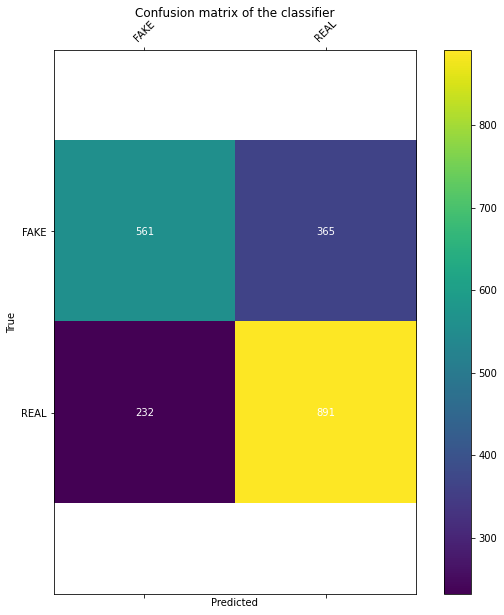

In [ ]:
lb=['REAL','FAKE']
actual=[x[1] for x in test_data]
error_classifier = train_classifier(train_data)
results = predict_labels([x[0] for x in test_data], error_classifier)
confusion_met=metrics.confusion_matrix(actual, results)
print('false positives=',confusion_met[1,0])
print('false negatives=',confusion_met[0,1])
confusion_matrix_heatmap(actual,results,['FAKE','REAL'])